In [1]:
import math
import pickle
import time
from functools import reduce

import dask.dataframe as ddf
import jqdatasdk as jq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from csmarapi.CsmarService import CsmarService
from plotly.subplots import make_subplots
from scipy import stats

from utils.my_cache import cache_wrapper

csmar = CsmarService()
from csmarapi.ReportUtil import ReportUtil

jq.auth('13764432461', 'Swisschina6')
csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

Mon 10 Oct 2022 15:24:10 CsmarService.py INFO User login succeed


auth success 


## **I. Data**

**Research**

- Most Data (nav/dividend/split ratio/asset allocation) : `CSMAR`

- Fund classification : `JoinQuant`

- Fund start date: `JoinQuant`

**Validation**

- `AMAC` : [2020 yearly report, page 15](https://www.amac.org.cn/researchstatistics/publication/zgzqtzjjynb/202104/t20210419_11390.html), for market statistic

- `Win.d` : classification/share/nav, for market statistic

<span style="color:blue">Data is sound, carefully verified and available to fetch</span>

AMAC

In [2]:
amac = pd.read_csv('data/AMAC/amac.csv', sep='\t', index_col=0).astype(float)
amac.index = pd.to_datetime(amac.index.astype(str)) + pd.Timedelta('180 days')

JoinQuant

In [3]:
@cache_wrapper(expire = 60 * 60 * 24 * 7)
# cache to avoid unnecessary traffic
def brief_of_funds(frequency : str = time.strftime('%W')) -> pd.DataFrame:
    return jq.get_all_securities(['fund', 'open_fund'], time.strftime('%Y%m%d'))


@cache_wrapper(expire = 60 * 60 * 24 * 7)
def main_info(fund_codes, frequency : str = time.strftime('%W')) -> pd.DataFrame:
    '''
    if you want to modify this function, delete cache and go on
    '''
    limit = jq.DBTable.RESULT_ROWS_LIMIT
    fund_code_cuts = np.array_split(fund_codes, math.ceil(len(fund_codes) / limit))
    full_table_cuts = []
    for code_cut in fund_code_cuts:
        # NOTE `in` is not applicable in filter, use `in_()` defined by joinquant
        table_cut = jq.finance.run_query(jq.query(jq.finance.FUND_MAIN_INFO).filter(jq.finance.FUND_MAIN_INFO.main_code.in_(code_cut)))
        full_table_cuts.append(table_cut)
    full_table = pd.concat(full_table_cuts).reset_index(drop=True)
    full_table['start_date'] = full_table.start_date.astype(np.datetime64).dt.to_period('M')
    return full_table


In [4]:
brief = brief_of_funds()
fund_codes = brief.index.str.split('.').str[0]
fund_main_info = main_info(fund_codes)

fund_main_info_ = fund_main_info[['main_code', 'underlying_asset_type']]

Win.d

In [5]:
wind_share_nav = pd.read_excel('data/Win.d/wind_share_nav.xlsx', sheet_name='Sheet1')
wind_classification = wind_share_nav[['证券代码', '投资类型(一级分类)']]
wind_share_nav = pd.DataFrame(data=wind_share_nav.iloc[:, 3:].values, index=wind_share_nav.证券代码.values, \
    columns = pd.MultiIndex.from_tuples(list(map(lambda x: (x[:4], pd.to_datetime(x[12:22])), wind_share_nav.columns[3:])))).T.sort_index()
wind_share_nav.index = wind_share_nav.index.set_levels(wind_share_nav.index.levels[1].to_period('M'), level=1)

CSMAR

In [6]:
maininfo = pd.read_csv('data/CSMAR/FUND_MainInfo.csv', parse_dates=['InceptionDate'])
maininfo['InceptionDate'] = maininfo.InceptionDate.dt.to_period('M')

symbol_code_mapping = pd.read_csv('data/CSMAR/FUND_FundCodeInfo.csv')
symbol_code_mapping = symbol_code_mapping[['MasterFundCode', 'Symbol']].drop_duplicates()
symbol_code_mapping['Symbol'] = symbol_code_mapping.Symbol.astype(str).str.zfill(6)

share_info = pd.read_csv('data/CSMAR/Fund_ShareChange.csv', parse_dates=['EndDate'])
share_info = share_info.rename(columns={'EndDate': 'Date'})
share_info['Date'] = share_info.Date.dt.to_period('M')
share_info['Symbol'] = share_info.Symbol.astype(str).str.zfill(6)
# share_info = share_info.set_index('Date').sort_index()

nav_daily = ddf.read_csv('data/CSMAR/daily_nav/*').compute()
nav_daily = nav_daily.rename(columns={'TradingDate': 'Date'})
# * heavy time complexity
# * if change Symbol to String now, program will be much slower
# nav_daily['Symbol'] = nav_daily.Symbol.astype(str).str.zfill(6)
nav_daily['Date'] = pd.to_datetime(nav_daily.Date)
# nav_daily = nav_daily.set_index('Date')[['Symbol', 'NAV']].sort_index()

fund_dividend = pd.read_csv('data/CSMAR/Fund_FundDividend.csv', parse_dates=['PrimaryExDividendDate', 'SecondaryExDividendDate'])
fund_dividend['Symbol'] = fund_dividend.Symbol.astype(str).str.zfill(6)
ExDividendMonth = fund_dividend.PrimaryExDividendDate.copy()
ExDividendMonth.name = 'ExDividendMonth'
ExDividendMonth[ExDividendMonth.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendMonth.isnull()].copy()
fund_dividend['ExDividendMonth'] = ExDividendMonth
fund_dividend = fund_dividend[['Symbol', 'ExDividendMonth', 'DividendperShare']]
fund_dividend = fund_dividend.rename(columns={'ExDividendMonth': 'Date'})
fund_dividend['DividendperShare'] = fund_dividend.DividendperShare.fillna(0)
fund_dividend['Date'] = fund_dividend.Date.dt.to_period('M')
fund_dividend = pd.DataFrame(fund_dividend.groupby(['Symbol', 'Date']).sum().to_records())
# fund_dividend = fund_dividend.set_index('Date').sort_index()

resolution = pd.read_csv('data/CSMAR/Fund_Resolution.csv', parse_dates=['DeclareDate'])
resolution['Symbol'] = resolution.Symbol.astype(str).str.zfill(6)
resolution = resolution.rename(columns={'DeclareDate': 'Date'})
resolution['SplitRatio'] = resolution.SplitRatio.fillna(1)
resolution['Date'] = resolution.Date.dt.to_period('M')
resolution = pd.DataFrame(resolution.groupby(['Symbol', 'Date']).prod().to_records())
# resolution = resolution.set_index('Date').sort_index()

allocation = pd.read_csv('data/CSMAR/Fund_Allocation.csv', parse_dates=['EndDate'])
allocation = allocation.rename(columns={'EndDate': 'Date'})
allocation['Date'] = allocation.Date.dt.to_period('M')
# allocation = allocation.set_index('Date').sort_index()


## **II. Market Statistic**

split Win.d data

|       | share            | nav            |
| ----- | ---------------- | -------------- |
| stock | stock fund share | stock fund nav |
| mixed | mixed fund share | mixed fund nav |

In [7]:
wind_share = wind_share_nav.loc['基金份额', slice(None)]
wind_share.columns = wind_share.columns.str.split('.').str[0]
wind_share = wind_share[ ~ wind_share.index.duplicated(keep='last')]

In [8]:
wind_nav = wind_share_nav.loc['单位净值', slice(None)]
wind_nav.columns = wind_nav.columns.str.split('.').str[0]
wind_nav = wind_nav[ ~ wind_nav.index.duplicated(keep='last')]

In [9]:
wind_stock_fund_share = wind_share.T[(wind_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_mixed_fund_share = wind_share.T[(wind_classification['投资类型(一级分类)'] == '混合型基金').values].T

wind_stock_fund_nav = wind_nav.T[(wind_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_mixed_fund_nav = wind_nav.T[(wind_classification['投资类型(一级分类)'] == '混合型基金').values].T

make Win.d data plottable

In [10]:
wind_stock_fund_num = pd.notna(wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_num.index = wind_stock_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_mixed_fund_num = pd.notna(wind_mixed_fund_nav).sum(axis=1)
wind_mixed_fund_num.index = wind_mixed_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_stock_fund_mkt_value = (wind_stock_fund_share * wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_mkt_value.index  = wind_stock_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_mixed_fund_mkt_value = (wind_mixed_fund_share * wind_mixed_fund_nav).sum(axis=1)
wind_mixed_fund_mkt_value.index  = wind_mixed_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)


align JoinQuant && CSMAR data

In [11]:
# may cache this cell to speed up
nav_monthly = nav_daily.groupby('Symbol').apply(lambda x: x.set_index('Date').resample('M').last()).NAV
nav_monthly = nav_monthly.unstack(level=0)
nav_monthly.index = nav_monthly.index.to_period('M')
nav_monthly.columns = nav_monthly.columns.astype(str).str.zfill(6)

In [12]:
share_info_ = share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')

In [13]:
selected_month = 6

share_info_6 = share_info_[share_info_.index.month == selected_month]
nav_monthly_6 = nav_monthly[nav_monthly.index.month == selected_month]

csmar_mixed_code_6 = np.intersect1d(nav_monthly_6.columns, fund_main_info_[fund_main_info_.underlying_asset_type == '混合型'].main_code.values)
csmar_mixed_code_6 = np.intersect1d(csmar_mixed_code_6, share_info_6.columns)

csmar_stock_code_6 = np.intersect1d(nav_monthly_6.columns, fund_main_info_[fund_main_info_.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, share_info_6.columns)

csmar_co_time_6 = np.intersect1d(share_info_6.index, nav_monthly_6.index)

In [14]:
csmar_mixed_mkt_value_jq_classify = (share_info_6.loc[csmar_co_time_6, csmar_mixed_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_mixed_code_6]).sum(axis=1)
csmar_stock_mkt_value_jq_classify = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6]).sum(axis=1)

csmar_stock_mkt_value_jq_classify.index = csmar_stock_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)
csmar_mixed_mkt_value_jq_classify.index = csmar_mixed_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

stock funds market value

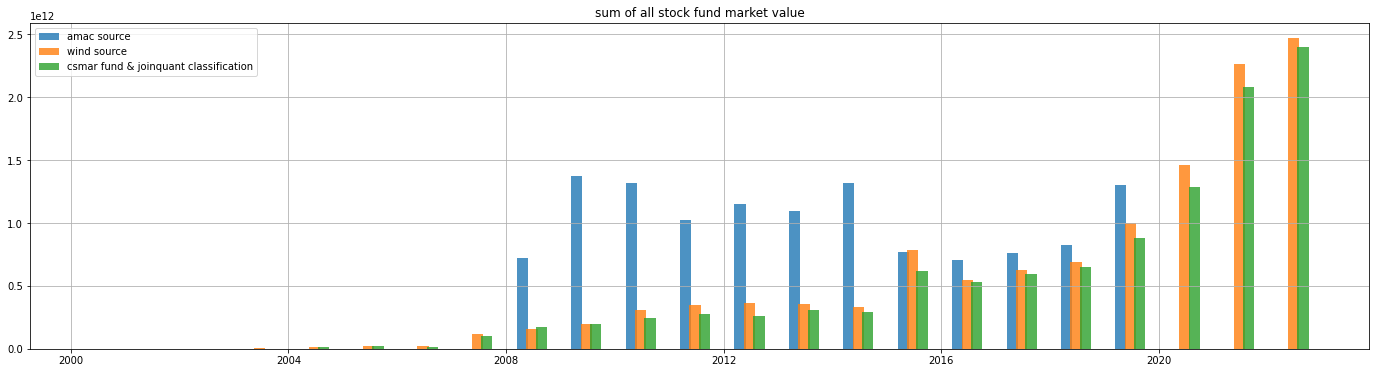

In [15]:
plt.figure(figsize=(24, 6))
plt.bar(amac.股票基金.index - pd.Timedelta('10W'), amac.股票基金.values * 1e8, width=75, label='amac source', alpha=.8)
plt.bar(wind_stock_fund_mkt_value.index - pd.Timedelta('1W'), wind_stock_fund_mkt_value.values, width=75, label='wind source', alpha=.8)
plt.bar(csmar_stock_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_stock_mkt_value_jq_classify.values, width=75, label='csmar fund & joinquant classification', alpha=.8)
plt.grid()
plt.title('sum of all stock fund market value')
plt.legend()

mixed funds market value

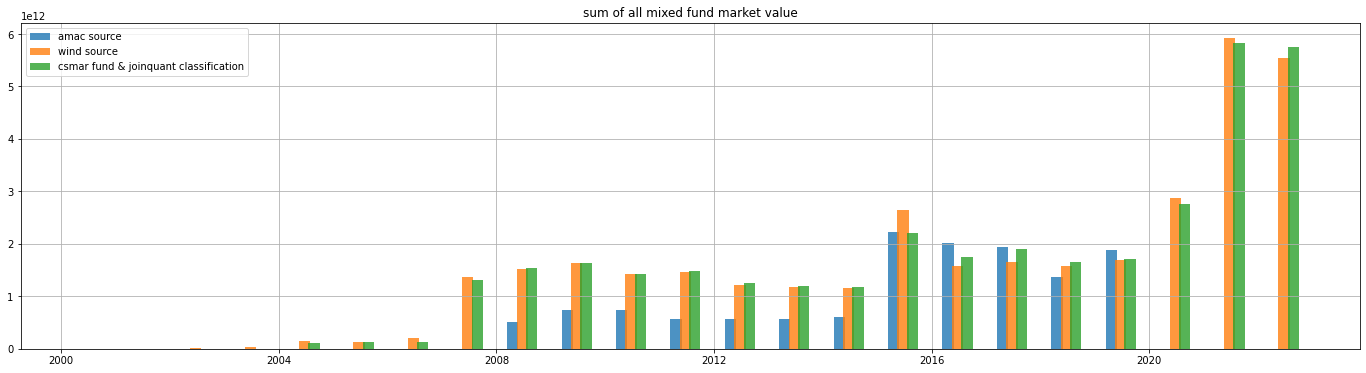

In [16]:
plt.figure(figsize=(24, 6))
plt.bar(amac.混合基金.index - pd.Timedelta('10W'), amac.混合基金.values * 1e8, width=75, label='amac source', alpha=.8)
plt.bar(wind_mixed_fund_mkt_value.index - pd.Timedelta('1W'), wind_mixed_fund_mkt_value.values, width=75, label='wind source', alpha=.8)
plt.bar(csmar_mixed_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_mixed_mkt_value_jq_classify.values, width=75, label='csmar fund & joinquant classification', alpha=.8)
plt.grid()
plt.title('sum of all mixed fund market value')
plt.legend()

(stock + mixed) funds market value

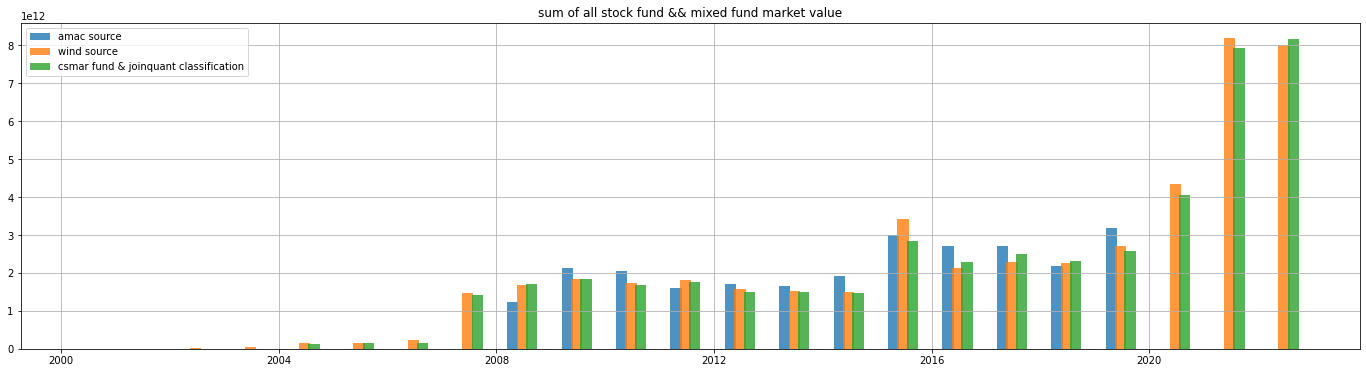

In [17]:
plt.figure(figsize=(24, 6))
plt.bar(amac.混合基金.index - pd.Timedelta('10W'), (amac.混合基金.values + amac.股票基金.values) * 1e8, width=75, label='amac source', alpha=.8)
plt.bar(wind_mixed_fund_mkt_value.index - pd.Timedelta('1W'), \
     wind_mixed_fund_mkt_value.values + wind_stock_fund_mkt_value.values, width=75, label='wind source', alpha=.8)
plt.bar(csmar_mixed_mkt_value_jq_classify.index + pd.Timedelta('8W'), \
     csmar_mixed_mkt_value_jq_classify.values + csmar_stock_mkt_value_jq_classify.values, width=75, label='csmar fund & joinquant classification', alpha=.8)
plt.grid()
plt.title('sum of all stock fund && mixed fund market value')
plt.legend()

fund counts

In [18]:
csmar_stock_fund_count = nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_mixed_fund_count = nav_monthly.loc[:, csmar_mixed_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_mixed_fund_count.index = csmar_mixed_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

integrated plot

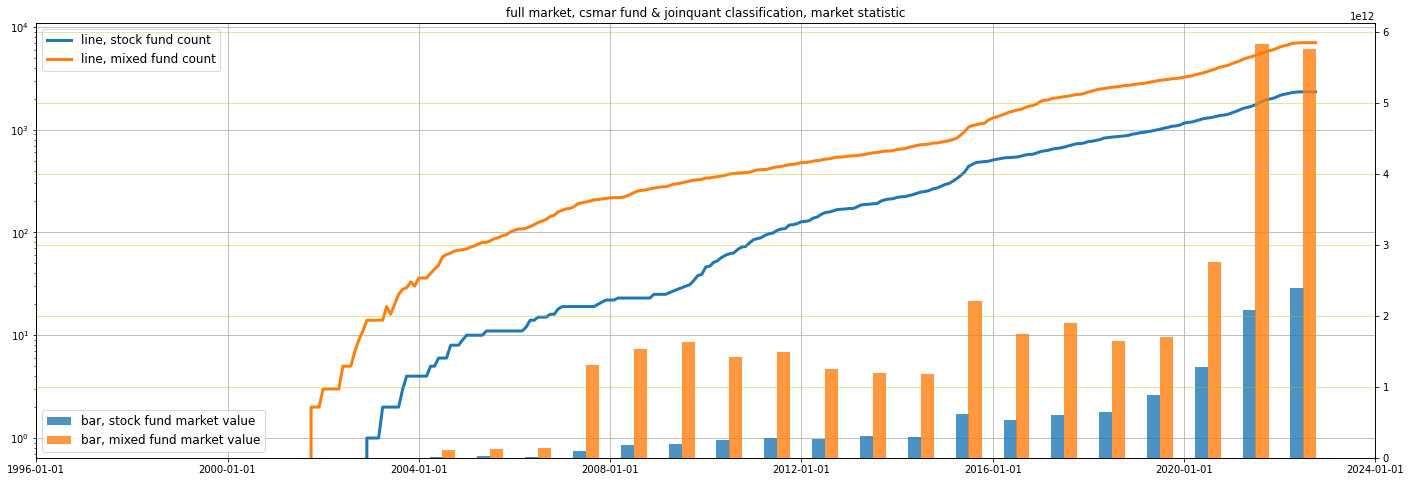

In [19]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

nav_monthly_6.loc[:, csmar_mixed_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)

ax1.plot(csmar_stock_fund_count, linewidth=3, label='line, stock fund count')
ax1.plot(csmar_mixed_fund_count, linewidth=3, label='line, mixed fund count')

ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()

ax2 = ax1.twinx()

plt.bar(csmar_stock_mkt_value_jq_classify.index - pd.Timedelta('7W'), \
     csmar_stock_mkt_value_jq_classify.values, width=100, label='bar, stock fund market value', alpha=.8)

plt.bar(csmar_mixed_mkt_value_jq_classify.index + pd.Timedelta('7W'), \
     csmar_mixed_mkt_value_jq_classify.values, width=100, label='bar, mixed fund market value', alpha=.8)

plt.title('full market, csmar fund & joinquant classification, market statistic')

ax2.grid(color='y', alpha=.5)
ax2.set_xticks(ax2.get_xticks()[::1])

ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='lower left', fontsize=12)

pass

## **III. Filters**

### preview

In [20]:
csmar_jq_co_fund = np.intersect1d(np.char.zfill(nav_daily.Symbol.unique().astype(str), 6), fund_main_info.main_code)
csmar_jq_co_fund = pd.Series(csmar_jq_co_fund, name='main_code')

final_main_info = pd.merge(fund_main_info, csmar_jq_co_fund, on='main_code')[['main_code', 'name', 'operate_mode', 'underlying_asset_type', 'invest_style', 'start_date']]

In [21]:
specs = [[{'type':'domain'}] * 2]

fig = make_subplots(rows=1, cols=2, specs=specs)
fig.add_trace(go.Pie(labels=final_main_info.underlying_asset_type.value_counts().index, values=final_main_info.underlying_asset_type.value_counts().values), 1, 1)
fig.add_trace(go.Pie(labels=final_main_info.operate_mode.value_counts().index, values=final_main_info.operate_mode.value_counts().values), 1, 2)

fig.update_layout(width=1200, height=500)

### 1. static filtering

（1）基金类别为“股票型基金”或“混合型基金”；


（2）基金为“开放式基金”

<!-- （2）非 ETF 类基金；

（3）非 QDII 类基金；

（4）主动管理标识为 1 或者为空； -->



In [22]:
filter_1 = np.logical_or(final_main_info.underlying_asset_type == '股票型', final_main_info.underlying_asset_type == '混合型')
filter_2 = final_main_info.operate_mode == '开放式基金'

filters = [(1, filter_1), (2, filter_2)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(final_main_info)

# proportional data left

array([0.6202964 , 0.76209063])

In [23]:
def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(final_main_info)} to {previous[1].sum()}')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}')
        return temp


filters_ = reduce(func, filters)

filter 1: 16397 to 10171
filter 2: 10171 to 7307


In [24]:
final_main_info_ = final_main_info[filters_]
final_main_info_.set_index('main_code').sort_index()

,name,operate_mode,underlying_asset_type,invest_style,start_date
main_code,,,,,
000001,华夏成长,开放式基金,混合型,偏股混合型,2001-12
000006,西部利得量化成长混合,开放式基金,混合型,偏股混合型,2019-03
000011,华夏大盘,开放式基金,混合型,偏股混合型,2004-08
000017,财通可持续混合,开放式基金,混合型,偏股混合型,2013-03
000020,景顺品质,开放式基金,混合型,偏股混合型,2013-03
...,...,...,...,...,...
968045,摩根股息人民币对冲(每月派息),开放式基金,股票型,普通股票型,2019-03
968046,摩根股息美元(累计),开放式基金,股票型,普通股票型,2019-03
968047,摩根股息美元(每月派息),开放式基金,股票型,普通股票型,2019-03


### 2. big table

from `code` indexed only to `code-month` multiIndex

In [25]:
indexes = pd.MultiIndex.from_product([final_main_info_.main_code.sort_values().values, pd.date_range('2000-1', '2022-10', freq='M')])
temp_codes = indexes.get_level_values(0)
temp_date = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['main_code'] = temp_codes
main_data['Date'] = temp_date.to_period('M')
main_data = pd.merge(main_data, final_main_info_, on='main_code')
main_data = main_data.rename(columns={'main_code': 'Symbol'})
main_data = main_data.set_index(['Symbol', 'Date'])
main_data = main_data.loc[nav_monthly[final_main_info_.main_code.sort_values().values].stack().index.swaplevel()].sort_index()
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                     
000001 2001-12           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-01           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-02           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-03           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-04           华夏成长        开放式基金                   混合型        偏股混合型   
...                       ...          ...                   ...          ...   
968049 2022-05  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-06  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-07  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-08  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-09  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   

               start_date  
Symbol Date                
000001 2001-12    2001-12  
       2002-01    2001-12  
       2002-02    2001-12  
       2002-03    2001-12  
       2002-04    2001-12  
...                   ...  
968049 2022-05    2019-03  
       2022-06    2019-03  
       2022-07    2019-03  
       2022-08    2019-03  
       2022-09    2019-03  

[358522 rows x 5 columns]

### 3. dynamic filtering

（3）基金上市时间超过一年

（4）最近一次**二季度报/年报/半年报**~~年报或半年报~~披露的中国市场股票持股比例超过总管理规模的30%

In [26]:
main_data = main_data[main_data.index.get_level_values(1) >= main_data.start_date + pd.offsets.MonthEnd(12)]
record_shape = len(main_data.index.get_level_values(0).unique())
f'in view of 2022, filter 3: {len(final_main_info_)} to {record_shape}'

'in view of 2022, filter 3: 7307 to 5846'

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

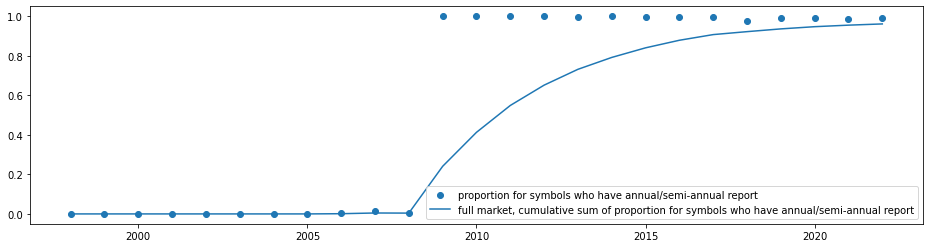

In [27]:
allocation['report_type_check'] = allocation.Date.dt.year
report_type_check = allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index, y=report_type_check_.values, label='proportion for symbols who have annual/semi-annual report')
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index, temp.values, label='full market, cumulative sum of proportion for symbols who have annual/semi-annual report')
plt.legend()
pass

<img src="image/README/2008_search.png" alt="drawing" width="500"/> <img src="image/README/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


使用存在二季度报/年报/半年报的数据

In [28]:
allocation_ = allocation[allocation.ReportTypeID.isin([2, 5, 6])]
allocation_ = pd.merge(allocation_, symbol_code_mapping, on='MasterFundCode', how='left')
allocation_ = allocation_[allocation_.Symbol.isin(main_data.index.get_level_values(0).unique())]
main_data = main_data.loc[allocation_.Symbol.unique(), slice(None)]

中国市场股票持股比例超过总管理规模30%

In [29]:
filter_4 = allocation_[(allocation_.Equity / allocation_.TotalAsset) > .3]
co_index = np.intersect1d(filter_4.set_index(['Symbol', 'Date']).index, main_data.index)
main_data['filter_4'] = np.nan
main_data.loc[main_data.index.get_level_values(1).month == 6, 'filter_4'] = False
main_data.loc[co_index, 'filter_4'] = True
main_data = main_data.groupby(level=0).fillna(method='ffill').fillna(False)
main_data = main_data[main_data.filter_4].drop('filter_4', axis=1)
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                  
000001 2003-06        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-07        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-08        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-09        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-10        华夏成长        开放式基金                   混合型        偏股混合型   
...                    ...          ...                   ...          ...   
012243 2022-09  东方红内需增长混合B        开放式基金                   混合型        偏股混合型   
910028 2022-06   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-07   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-08   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-09   东方红内需增长混合        开放式基金                   混合型        偏股混合型   

               start_date  
Symbol Date                
000001 2003-06    2001-12  
       2003-07    2001-12  
       2003-08    2001-12  
       2003-09    2001-12  
       2003-10    2001-12  
...                   ...  
012243 2022-09    2021-06  
910028 2022-06    2021-06  
       2022-07    2021-06  
       2022-08    2021-06  
       2022-09    2021-06  

[211437 rows x 5 columns]

In [30]:
f'in view of all time span, filter 4: {record_shape} to {len(main_data.index.get_level_values(0).unique())}'

'in view of all time span, filter 4: 5846 to 4642'

### 4. full data

reset nav

In [31]:
nav_monthly_ = pd.Series(nav_monthly.stack().swaplevel(), name='NAV')
nav_monthly_ = pd.DataFrame(nav_monthly_).reset_index()

merge data

In [32]:
main_data = pd.merge(main_data, nav_monthly_, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, fund_dividend, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, resolution, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])

handle NA

In [33]:
main_data['NAV'] = main_data.groupby(level=0).apply(lambda x: x.NAV.fillna(method='ffill')).droplevel(0)
main_data['DividendperShare'] = main_data.DividendperShare.fillna(0)
main_data['SplitRatio'] = main_data.SplitRatio.fillna(1)

combine csmar category

In [34]:
csmar_category_symbol_mapping = pd.merge(maininfo[['MasterFundCode', 'Category']].drop_duplicates(), \
    symbol_code_mapping, on='MasterFundCode', how='left')[['Category', 'Symbol']]
csmar_category_symbol_mapping = csmar_category_symbol_mapping.drop_duplicates().reset_index(drop=True)
csmar_category_symbol_mapping = csmar_category_symbol_mapping.groupby('Symbol').last()

main_data = pd.merge(main_data.reset_index(), csmar_category_symbol_mapping, on='Symbol').set_index(['Symbol', 'Date'])
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                  
000001 2003-06        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-07        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-08        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-09        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-10        华夏成长        开放式基金                   混合型        偏股混合型   
...                    ...          ...                   ...          ...   
012243 2022-09  东方红内需增长混合B        开放式基金                   混合型        偏股混合型   
910028 2022-06   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-07   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-08   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-09   东方红内需增长混合        开放式基金                   混合型        偏股混合型   

               start_date     NAV  DividendperShare  SplitRatio Category  
Symbol Date                                                               
000001 2003-06    2001-12  0.9730             0.033         1.0    混合型基金  
       2003-07    2001-12  0.9860             0.000         1.0    混合型基金  
       2003-08    2001-12  0.9540             0.000         1.0    混合型基金  
       2003-09    2001-12  0.9200             0.000         1.0    混合型基金  
       2003-10    2001-12  0.9360             0.000         1.0    混合型基金  
...                   ...     ...               ...         ...      ...  
012243 2022-09    2021-06  3.1259             0.000         1.0    混合型基金  
910028 2022-06    2021-06  3.6542             0.000         1.0    混合型基金  
       2022-07    2021-06  3.6414             0.000         1.0    混合型基金  
       2022-08    2021-06  3.3234             0.000         1.0    混合型基金  
       2022-09    2021-06  3.1545             0.000         1.0    混合型基金  

[211333 rows x 9 columns]

## **IV. Return**

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}\tag{1}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

当$t$月中发生比例为$s_t$的拆分时, $SF_t=s_tSF_{t-1}$

公式等价于

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*s_t}{NAV_{t-1}}\tag{2}
$$

### 1. prepare

NAV_shift calculation

In [35]:
main_data['NAV_shift'] = main_data.groupby(level=0).apply(lambda x: x.NAV.shift(1)).droplevel(0)

split into stock fund and mixed fund

apply formula

In [36]:
# JoinQuant classification
mixed_data = main_data[main_data.underlying_asset_type == '混合型']
stock_data = main_data[main_data.underlying_asset_type == '股票型']

# CSMAR classification
# mixed_data = main_data.reset_index()[main_data.reset_index().Symbol.isin(\
#     csmar_category_symbol_mapping[csmar_category_symbol_mapping.Category == '混合型基金'].Symbol)].set_index(['Symbol', 'Date'])
# stock_data = main_data.reset_index()[main_data.reset_index().Symbol.isin(\
#     csmar_category_symbol_mapping[csmar_category_symbol_mapping.Category == '股票型基金'].Symbol)].set_index(['Symbol', 'Date'])


return_of_stock_fund = stock_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)
return_of_mixed_fund = mixed_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.SplitRatio) / x.NAV_shift).droplevel(0)

market value weight generation

In [37]:
stock_fund_weight = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6])
# 
stock_fund_weight = pd.concat([stock_fund_weight, \
    pd.DataFrame([[np.nan] * stock_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight.columns)])

stock_fund_weight = stock_fund_weight.resample('M').ffill()

stock_fund_dates = return_of_stock_fund.unstack(level=0).index
stock_fund_funds = return_of_stock_fund.unstack(level=0).columns

stock_fund_new = np.setdiff1d(stock_fund_funds, stock_fund_weight.columns)
print(f'{stock_fund_new} will not be used')
stock_fund_funds = np.intersect1d(stock_fund_funds, stock_fund_weight.columns)

stock_fund_weight = stock_fund_weight.loc[stock_fund_dates, stock_fund_funds]
stock_fund_weight = stock_fund_weight.div(stock_fund_weight.sum(axis=1), axis=0)

[] will not be used


In [38]:
mixed_fund_weight = (share_info_6.loc[csmar_co_time_6, csmar_mixed_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_mixed_code_6])
mixed_fund_weight = pd.concat([mixed_fund_weight, \
    pd.DataFrame([[np.nan] * mixed_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=mixed_fund_weight.columns)])
mixed_fund_weight = mixed_fund_weight.resample('M').ffill()

mixed_fund_dates = return_of_mixed_fund.unstack(level=0).index
mixed_fund_funds = return_of_mixed_fund.unstack(level=0).columns

mixed_fund_new = np.setdiff1d(mixed_fund_funds, mixed_fund_weight.columns)
print(f'{mixed_fund_new} will not be used')
mixed_fund_funds = np.intersect1d(mixed_fund_funds, mixed_fund_weight.columns)

mixed_fund_weight = mixed_fund_weight.loc[mixed_fund_dates, mixed_fund_funds]
mixed_fund_weight = mixed_fund_weight.div(mixed_fund_weight.sum(axis=1), axis=0)

['960002' '960004'] will not be used


### 2. analysis

data later than 2005-06

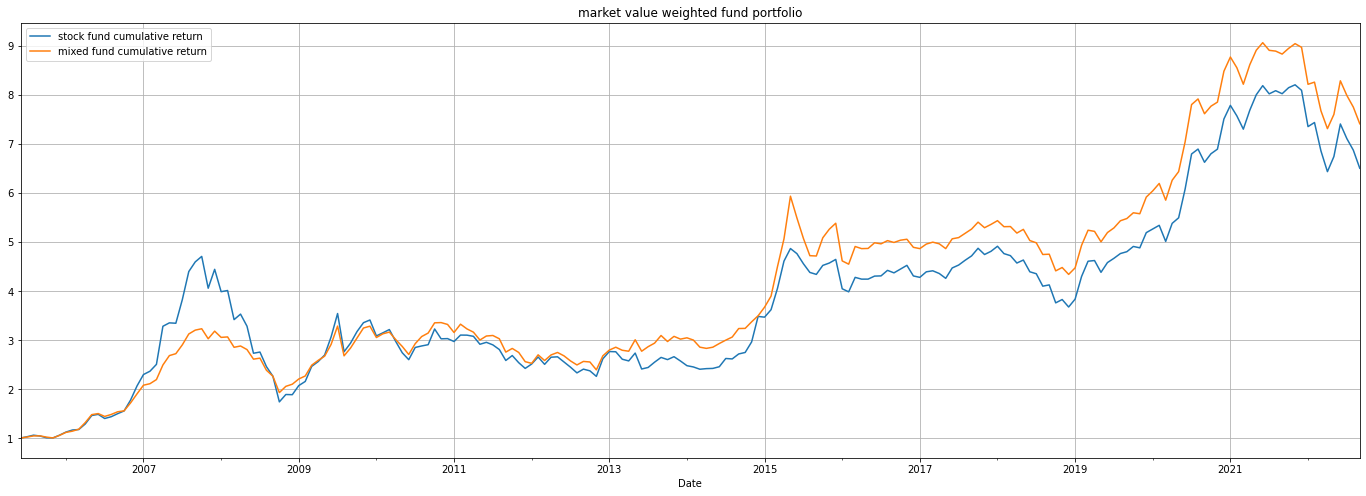

In [48]:
plt.figure(figsize=(24,8))

# 高收益混合型基金收益来源
(((return_of_stock_fund.unstack(level=0) - 1) * stock_fund_weight).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='stock fund cumulative return')
(((return_of_mixed_fund.unstack(level=0) - 1) * mixed_fund_weight).sum(axis=1) + 1).loc['2005-6':].cumprod().plot(label='mixed fund cumulative return')
plt.title('market value weighted fund portfolio')
plt.grid()
plt.legend()

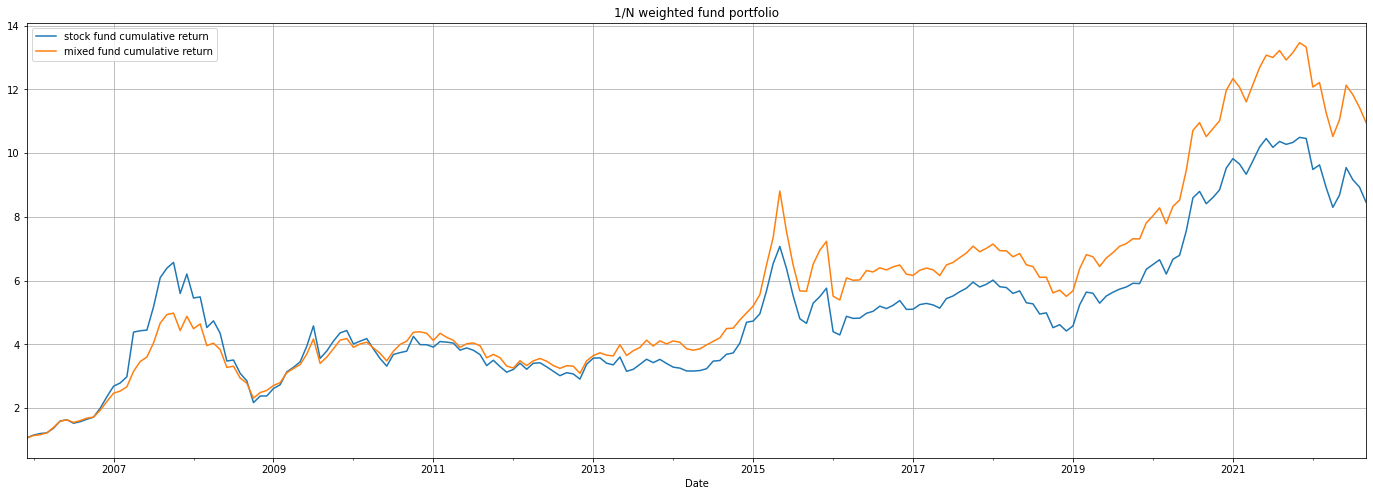

In [49]:
plt.figure(figsize=(24,8))
return_of_stock_fund.groupby(level=1).mean().loc['2005-12':].cumprod().plot(label='stock fund cumulative return')
return_of_mixed_fund.groupby(level=1).mean().loc['2005-12':].cumprod().plot(label='mixed fund cumulative return')
plt.title('1/N weighted fund portfolio')
plt.grid()
plt.legend()

why use data later than 2005-06?

In [41]:
co_time = np.intersect1d(share_info_.index, nav_monthly.index)
co_stocks = np.intersect1d(share_info_.columns, nav_monthly.columns)
compare_share_info = share_info_.loc[co_time, co_stocks]
compare_nav_monthly = nav_monthly.loc[co_time, co_stocks]

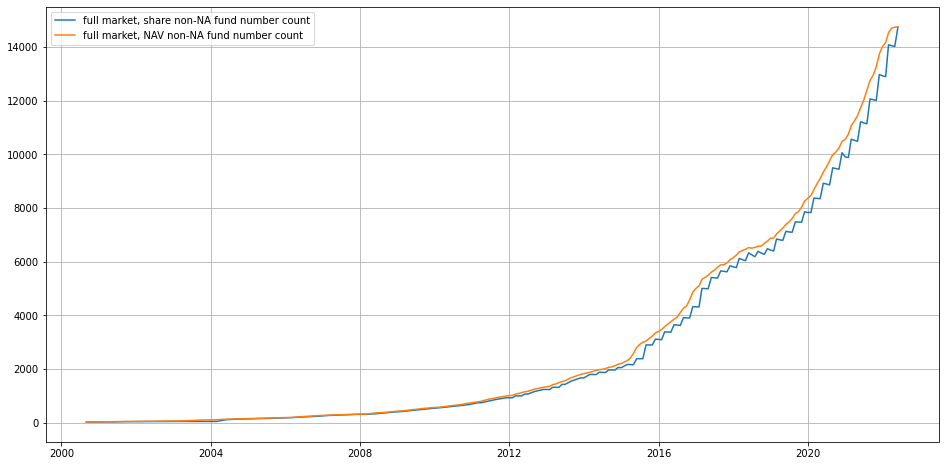

In [42]:
filled_share_info = compare_share_info.fillna(method='ffill')
plt.figure(figsize=(16, 8))
def na_compare(row):
    date = row.name
    available_funds = row.dropna().index
    selected_share_info = (row * filled_share_info.loc[date]).dropna()
    available_share_funds = selected_share_info.index

    return [len(available_share_funds), len(available_funds)]

temp = np.array(list(compare_nav_monthly.apply(na_compare, axis=1).values))
plt.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 0], label='full market, share non-NA fund number count')
plt.plot(compare_nav_monthly.index.astype(np.datetime64), temp[:, 1], label='full market, NAV non-NA fund number count')
plt.legend()
plt.grid()

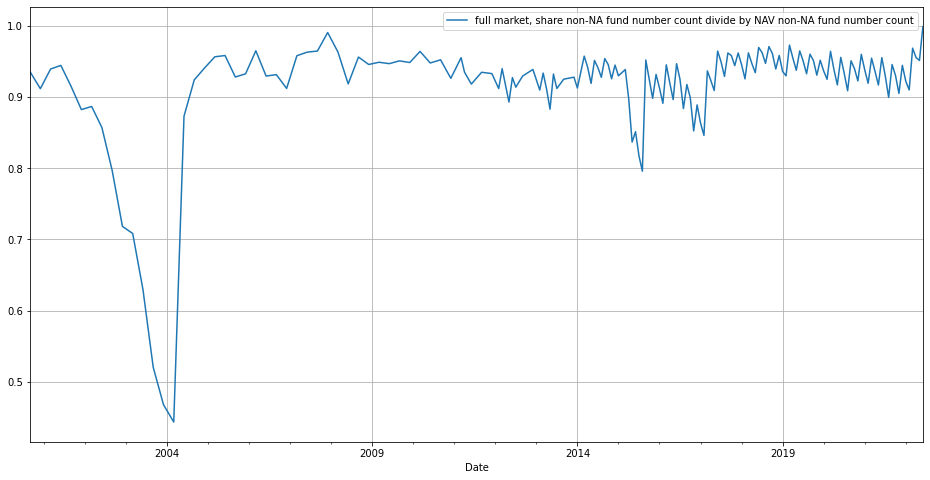

In [43]:
plt.figure(figsize=(16, 8))
pd.Series(temp[:, 0] / temp[:, 1] ,index=compare_nav_monthly.index).plot(label='full market, share non-NA fund number count divide by NAV non-NA fund number count')
plt.legend()
plt.grid()

Size effect in fund?

<AxesSubplot:title={'center':'cumulative return in long-short stock funds 3 groups'}, xlabel='Date'>

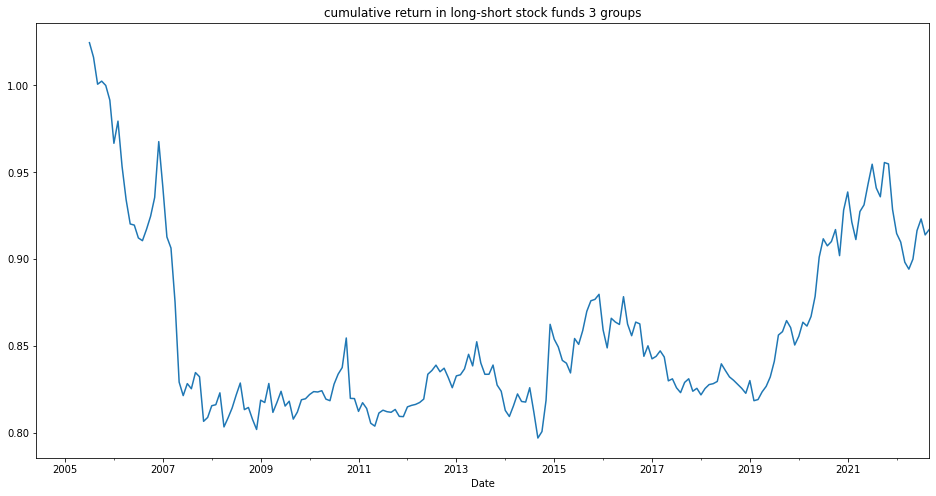

In [61]:
stock_fund_weight_ = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6])
stock_fund_weight_ = pd.concat([stock_fund_weight_, \
    pd.DataFrame([[np.nan] * stock_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight_.columns)])
stock_fund_weight_ = stock_fund_weight_.resample('M').ffill()

groups = 3
ret_stock_fund = return_of_stock_fund.unstack(0) - 1
stock_fund_groups = stock_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(stock_fund_groups.index, ret_stock_fund.index)
co_stocks = np.intersect1d(stock_fund_groups.columns, ret_stock_fund.columns)

stock_fund_groups = stock_fund_groups.loc[co_time, co_stocks]
ret_stock_fund = ret_stock_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, stock_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result

stock_grouped_return = ret_stock_fund.apply(func, axis=1)
plt.figure(figsize=(16, 8))
plt.title(f'cumulative return in long-short stock funds {groups} groups')
(stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0] + 1).cumprod().plot()


In [62]:
stats.ttest_1samp((stock_grouped_return.iloc[:, -1] - stock_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-0.3712326871145363, pvalue=0.6445771294168032)

<AxesSubplot:title={'center':'cumulative return in long-short mixed funds 3 groups'}, xlabel='Date'>

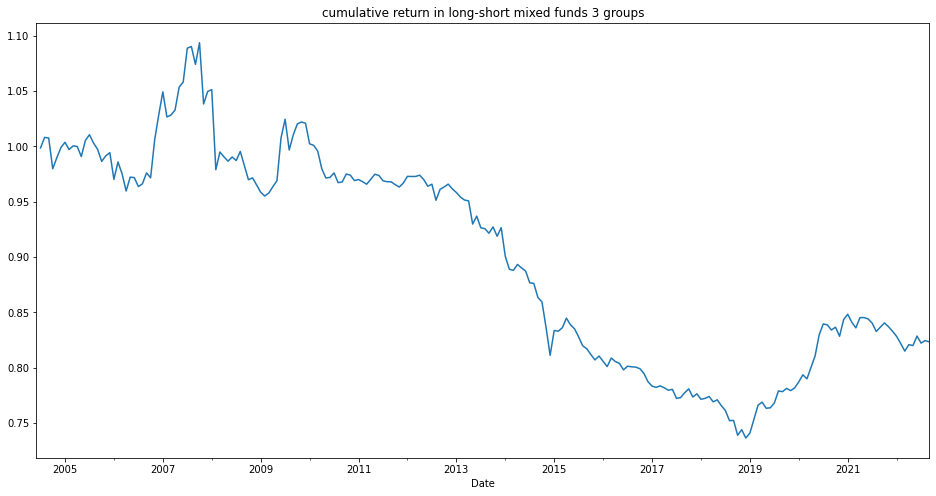

In [63]:
mixed_fund_weight_ = (share_info_6.loc[csmar_co_time_6, csmar_mixed_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_mixed_code_6])
mixed_fund_weight_ = pd.concat([mixed_fund_weight_, \
    pd.DataFrame([[np.nan] * mixed_fund_weight_.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=mixed_fund_weight_.columns)])
mixed_fund_weight_ = mixed_fund_weight_.resample('M').ffill()

groups = 3
ret_mixed_fund = return_of_mixed_fund.unstack(0) - 1
mixed_fund_groups = mixed_fund_weight_.dropna(how='all').apply(lambda x: pd.qcut(x, groups, labels=np.arange(groups)) if not pd.isna(x).all() else x, axis=1)
co_time = np.intersect1d(mixed_fund_groups.index, ret_mixed_fund.index)
co_stocks = np.intersect1d(mixed_fund_groups.columns, ret_mixed_fund.columns)

mixed_fund_groups = mixed_fund_groups.loc[co_time, co_stocks]
ret_mixed_fund = ret_mixed_fund.loc[co_time, co_stocks]

def func(x):
    date = x.name
    result = pd.DataFrame([x, mixed_fund_groups.loc[date]], index=['return', 'rank']).T.groupby('rank').mean().iloc[:, 0]
    if result.shape[0] < groups:
        
        return pd.Series([np.nan] * groups, name=date)
    else:
        return result
plt.figure(figsize=(16, 8))
plt.title(f'cumulative return in long-short mixed funds {groups} groups')
mixed_grouped_return = ret_mixed_fund.apply(func, axis=1)

(mixed_grouped_return.iloc[:, -1] - mixed_grouped_return.iloc[:, 0] + 1).cumprod().plot()

In [64]:
stats.ttest_1samp((mixed_grouped_return.iloc[:, -1] - mixed_grouped_return.iloc[:, 0]).dropna(), 0, alternative ='greater')

Ttest_1sampResult(statistic=-1.025866442813339, pvalue=0.8469542508537611)